In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()

# Variables

In [2]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 45                   # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

# k_folds = 10                # number of folds for k-fold validation                              #k-folds someday

val20_epochs45


# Import Data From Local Drive

In [3]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory=r"C:\Users\srika\OneDrive\Desktop\New folder\LungCancerDetection\LungCancerDetection\The IQ-OTHNCCD lung cancer dataset\train",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory=r"C:\Users\srika\OneDrive\Desktop\New folder\LungCancerDetection\LungCancerDetection\The IQ-OTHNCCD lung cancer dataset\test",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 767 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [4]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

#val_data,val_labels = val_data_gen.next()

In [5]:
import gc
gc.collect()

632

In [6]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(1097, 176, 208, 3)
(1097, 3)


In [7]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (767, 176, 208, 3)
validation (110, 176, 208, 3)
test (220, 176, 208, 3)


# Sanity Checks

In [8]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(767, 176, 208, 3)
(767, 3)
(110, 176, 208, 3)
(110, 3)
(220, 176, 208, 3)
(220, 3)


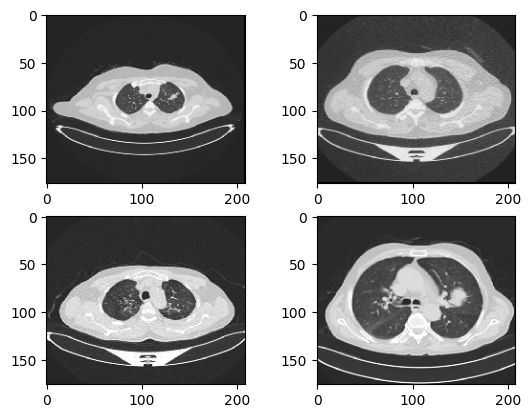

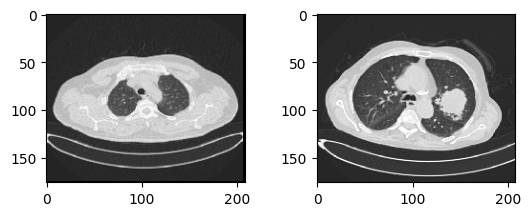

In [9]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [10]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


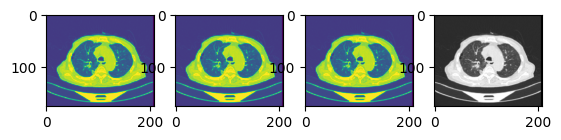

In [11]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [12]:
# import pre-trained VGG16 model
weight_path1 =r"C:\Users\srika\Dropbox\PC\Downloads\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
vg_model = tf.keras.applications.vgg16.VGG16(weights = weight_path1,include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [13]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

# always leave last layer trainable ##
vg_model.get_layer('block5_conv1').trainable = False
vg_model.get_layer('block5_conv2').trainable = False
vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(3,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [14]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train the Model



In [15]:
import torch 
torch.cuda.empty_cache() # PyTorch thing

In [16]:
batch_size = 16  # Reduce the batch size
model_history = vg_model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                            epochs=eps, batch_size=batch, shuffle=True)


Epoch 1/45
39/39 [==============================] - 17s 197ms/step - loss: 1.0676 - accuracy: 0.5385 - val_loss: 0.5781 - val_accuracy: 0.8000
Epoch 2/45
39/39 [==============================] - 5s 131ms/step - loss: 0.6613 - accuracy: 0.7601 - val_loss: 0.3927 - val_accuracy: 0.8909
Epoch 3/45
39/39 [==============================] - 5s 132ms/step - loss: 0.5002 - accuracy: 0.8214 - val_loss: 0.3010 - val_accuracy: 0.8727
Epoch 4/45
39/39 [==============================] - 5s 132ms/step - loss: 0.4094 - accuracy: 0.8357 - val_loss: 0.2744 - val_accuracy: 0.9000
Epoch 5/45
39/39 [==============================] - 5s 132ms/step - loss: 0.3923 - accuracy: 0.8501 - val_loss: 0.2453 - val_accuracy: 0.9182
Epoch 6/45
39/39 [==============================] - 5s 132ms/step - loss: 0.2966 - accuracy: 0.8905 - val_loss: 0.2303 - val_accuracy: 0.9273
Epoch 7/45
39/39 [==============================] - 5s 132ms/step - loss: 0.3289 - accuracy: 0.8696 - val_loss: 0.2107 - val_accuracy: 0.9455
Epoch

In [17]:
gc.collect()

1450

In [18]:
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

24/24 [==============================] - 4s 110ms/step - loss: 0.0037 - accuracy: 1.0000
Accuracy: 100.00%


In [19]:
gc.collect()

725

# Plots and Values

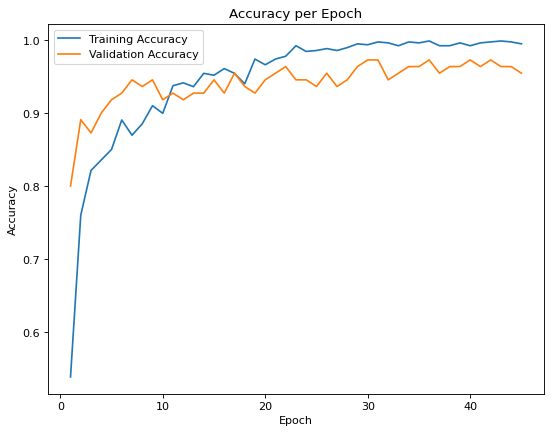

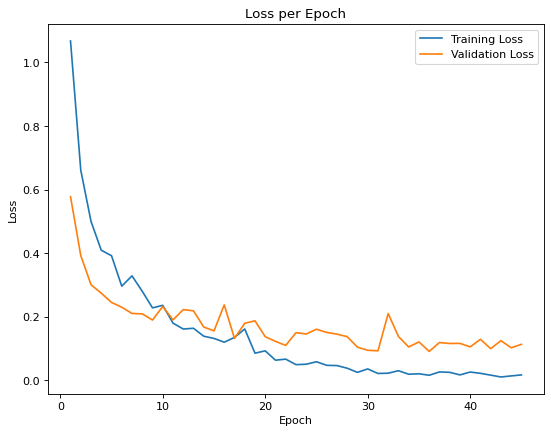

image dimensions:  (176, 208)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  45
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 04 minutes


In [20]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#print(np.amax.model_history.history['val_accuracy'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Performance Evaluation
Come here after loading model

In [21]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

7/7 [==============================] - 2s 236ms/step - loss: 0.1351 - accuracy: 0.9591
Train Accuracy: 100.00%
Validation Accuracy: 95.45%
Test Accuracy: 95.91%


7/7 [==============================] - 1s 55ms/step


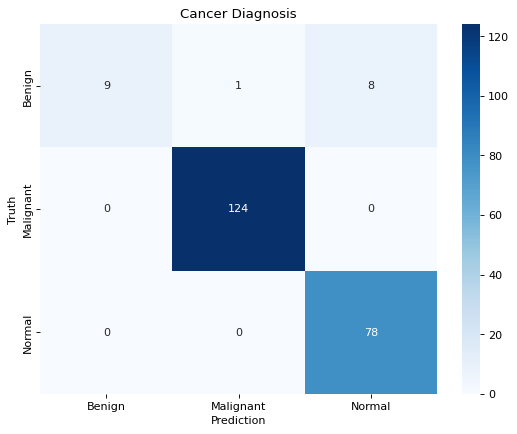

In [22]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
plt.title('Cancer Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
#plt.subplots(figsize=(9, 6))
plt.show(ax)


24/24 [==============================] - 1s 55ms/step


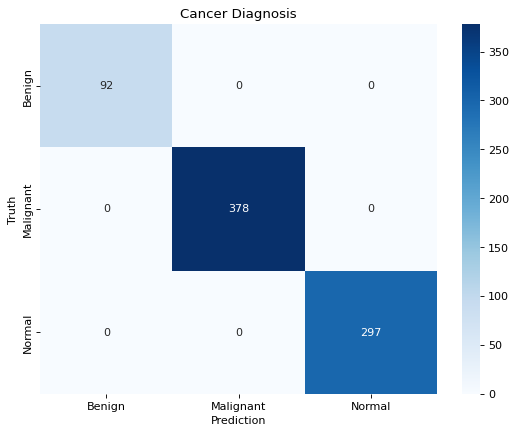

In [23]:
## CONFUSION MATRIX ##

predict = vg_model.predict(train_data)

predict = np.argmax(predict, axis=1)
labelst = np.argmax(train_labels, axis=1)

conf_arrt = confusion_matrix(labelst, predict)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arrt, cmap='Blues', annot=True, fmt='d', xticklabels= ['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
plt.title('Cancer Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
#plt.subplots(figsize=(9, 6))
plt.show(ax)


# Saving the Model

In [24]:
## saving in HDF5 format
save_name = '%s_testacc%2d.h5'%(save_model_name,(test_scores[1]*100))
vg_model.save("C:/Users/srika/OneDrive/Desktop/New folder/LungCancerDetection/LungCancerDetection/%s"%save_name)
print(save_name)


## save the model_history


val20_epochs45_testacc95.h5


# Load Model

In [25]:
#vg_model.save('C:/Users/srika/Dropbox/PC/Downloads/alz/Alzheimer_s Dataset/val20_epochs30_testacc94.h5')